In [266]:
import mne
import mne_nirs
import numpy as np
import matplotlib.pyplot as plt
import random

import pywt
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import os
import pandas as pd
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from scipy.special import gamma
from scipy.optimize import curve_fit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

from nilearn.plotting import plot_design_matrix


In [402]:
# Control variables that MUST be adjusted according your specifications and 

time_win = 26.3 # The duration of each window that we pass into the model
sample_rate = 8.93 # The sample rate of the fnirs signal, in Hz. 
signal_length = np.floor(time_win * sample_rate).astype(int) # The number of points in a default signal
norm_base = 16  # The base used in logarithmic normalisation 
time_signal = np.linspace(-1, time_win-1, signal_length)
amp = 3. # The amplitude scaling of generated canonical HRFs.

resting_state_path = "/Users/kostasdemiris/Downloads/snirf/"

# The database I used is from (citation->):
# Blanco B, Molnar M, Carreiras M, Caballero-Gaudes C. 
# Open access dataset of task-free hemodynamic activity in 4-month-old infants during sleep using fNIRS. 
# Sci Data. 2022 Mar 25;9(1):102. doi: 10.1038/s41597-022-01210-y. PMID: 35338168; PMCID: PMC8956728.


print(f"The number of points in each sample is {signal_length}")


The number of points in each sample is 234


In [392]:
# Loading data from files. Adjust accordingly if you are not using the same dataset.
def get_time_series_from_snirf_data(snirf_file_path):
    raw_object = mne.io.read_raw_snirf(snirf_file_path, verbose=False)
    raw_object.load_data()
    
    # Removes short channels. They're not useful for my single channel denoising program since they can't pick up
    # hrf signals
    raw_picks = mne.pick_types(raw_object.info, meg = False, fnirs = True)
    channel_distances = mne.preprocessing.nirs.source_detector_distances(raw_object.info, picks = raw_picks)
    raw_object.pick(raw_picks[channel_distances > 0.01])

    optical_density = mne.preprocessing.nirs.optical_density(raw_object)
    haemo_recording = mne.preprocessing.nirs.beer_lambert_law(optical_density, ppf=6)
    haemo_data = haemo_recording.get_data()
    
    return haemo_data    

def load_snirf_data(snirf_folder_path):
    readings = []
    
    if os.path.isdir(snirf_folder_path):
        for file_name in os.listdir(snirf_folder_path):
            if file_name.endswith('.snirf'):
                # Go through all the files in the folder, if they end with .snirf load them
                # Be careful that there is not duplicated or unwanted snirf files (e.g. ones that already have
                # synthetic hrf data overlayed onto them)
                snirf_file_path = os.path.join(snirf_folder_path, file_name)
                reading = get_time_series_from_snirf_data(snirf_file_path)
                readings.append(reading)
    
    # In many cases, (including the one I referenced above), readings are of varying length. 
    # This cuts them to the length of the shortest one, but if that is not desirable, load them individually instead
    cutoff_length = min(len(reading[0]) for reading in readings)
    standardised_readings = np.array([reading[0, :cutoff_length] for reading in readings])
    return standardised_readings
    
real_haemo_data = load_snirf_data(resting_state_path)
print(f"There are {len(real_haemo_data)} subjects, each with {len(real_haemo_data[0])/sample_rate} seconds of readings")

Reading 0 ... 8312  =      0.000 ...   930.944 secs...
Reading 0 ... 10013  =      0.000 ...  1121.456 secs...
Reading 0 ... 6509  =      0.000 ...   729.008 secs...
Reading 0 ... 13817  =      0.000 ...  1547.504 secs...
Reading 0 ... 7688  =      0.000 ...   861.056 secs...
Reading 0 ... 6011  =      0.000 ...   673.232 secs...
Reading 0 ... 10055  =      0.000 ...  1126.160 secs...
Reading 0 ... 6509  =      0.000 ...   729.008 secs...
Reading 0 ... 8045  =      0.000 ...   901.040 secs...
Reading 0 ... 9119  =      0.000 ...  1021.328 secs...
Reading 0 ... 10721  =      0.000 ...  1200.752 secs...
Reading 0 ... 9233  =      0.000 ...  1034.096 secs...
Reading 0 ... 12080  =      0.000 ...  1352.960 secs...
Reading 0 ... 8108  =      0.000 ...   908.096 secs...
Reading 0 ... 8084  =      0.000 ...   905.408 secs...
Reading 0 ... 5441  =      0.000 ...   609.392 secs...
Reading 0 ... 8084  =      0.000 ...   905.408 secs...
Reading 0 ... 8576  =      0.000 ...   960.512 secs...
Readi

In [491]:
class Display:
    # Just 
    def __init__(self, time_sig):
        self.time_signal = time_sig
    
    def display_gray_arr(self, img_arr):
        # Displays a padded wavelet as a gray image
        plt.imshow(img_arr, cmap='gray')
        plt.title("Wavelet As Image")
        plt.axis('off')
        plt.show()
    
    def plot_pChannel(self, points, time_series):
        # Plots individual channel data, but can
        plt.figure(figsize=(10, 4))
        plt.plot(time_series, points)
        plt.title("channel")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.show()
        plt.clf()
        
    def plot_multiChannel(self, channel_arr, time_series):
        fig, ax = plt.subplots()
        for i, array in enumerate(channel_arr):
            ax.plot(time_series, channel_arr[i], label="Channel {i+1}")
        ax.set_xlabel('Time: in seconds')
        ax.set_ylabel('Amplitude ')
        ax.set_title('Multiple Channels plotted on one image')
    
    def plot_scatter_data(self, data_points, central=0.5):
        # Useful for power spectra, not currently used but could be
        plt.scatter([i for i in range(len(data_points))], data_points, color='white', alpha=0.5)

        for i in range(len(data_points)):
            plt.plot([i, i], [data_points[i], central], color='red', alpha=0.5)

        plt.axhline(y=central, color='green', linestyle='--')

        plt.title('Scatter plot')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.show()
        
    def plot_comparision_data(self, original_data, reconstructed_data, time_signal):
        plt.figure(figsize=(10, 6))
        plt.plot(time_signal, original_data, label='Original')
        plt.plot(time_signal, reconstructed_data, label='Reconstructed')
        plt.title('Comparision')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.clf()
    
    def plot_many_comparision_series(self, time_series, time_signal):
        plt.figure(figsize=(10, 6))
        for series in range(1, len(time_series)+ 1):
            plt.plot(time_series[series-1], label='Series ' + str(series))
        plt.title('Comparision')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.clf()
        
    def plot_wavedec_spect(self, coeffs):
        coefficients_array = []
        max_length = max(len(i) for i in coeffs)
        
        for level, row in enumerate(coeffs):
            stretched_row = np.repeat(row, np.ceil(max_length / len(row)).astype(int))
            coefficients_array.append(stretched_row[:max_length]) # Again, this is just for display, not actually used
            
            
        coeffs_matrix = np.vstack(coefficients_array)
        norm_coeff_matrix = np.repeat(normalise(coeffs_matrix), 3, axis=0)
        
        print(f"shape is {np.shape(norm_coeff_matrix)}")
        plt.clf()
        plt.figure(figsize=(10, 5))
        plt.imshow(norm_coeff_matrix, cmap='brg')
        plt.colorbar(label='Magnitude')
        plt.ylabel('Depth')
        plt.xlabel('Time')
        plt.title('WAVEDEC DISPLAY SPECTOGRAM')
        plt.show()
        
    def plot_wavedec_layer(self, coeffs, start_time=-1, stop_time=time_win-1):
        for depth, row in enumerate(coeffs):
            plt.figure(figsize=(10, 4))
            time_row = np.linspace(start_time, stop_time, num=len(row))
            plt.plot(time_row, row)
            plt.title(f"wavelet level {depth + 1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.show()
            
    def plot_comp_wavedec_layer(self, coeffs, recoefs, start_time=-1, stop_time=time_win-1):
        for depth, row in enumerate(coeffs):
            plt.figure(figsize=(10, 4))
            time_row = np.linspace(start_time, stop_time, num=len(row))
            plt.plot(time_row, row, label='Original')
            plt.plot(time_row, recoefs[depth], label='Reconstructed')
            plt.title(f"wavelet level {depth + 1}")
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
            plt.legend()
            plt.show()
        
# Data Generation models
class Auto_Regressive_Model():
    # Uses the direct relation between the previous k (order) values to forecast the subsequent value in a time series
    # Suitable for when the ACF plot has a slowly decreasing tail, with the highest significant PACF value being order
    def __init__(self, order):
        self.k = order
        self.model = LinearRegression()
        self.std = None
            
    def generate_training_data(self, data):
        # returns the inp. data, an array of k long sequences, and outp. data, array of the respective k+i+1'th values
        n = len(data)
                
        x_data = np.reshape(data[:n - self.k], (-1, 1))
        for i in range(1, self.k):
            x_data = np.hstack((x_data, np.reshape(data[i: n - self.k + i], (-1, 1))))

        y_data = data[self.k:]
        return np.array(x_data), np.array(y_data)
    
    def fit(self, data):
        self.std = np.std(data)
        training_x, training_y = self.generate_training_data(data)
        self.model.fit(training_x, training_y)
    
    def predict(self, data, steps, mc_depth, iterative_averaging=False):
        # Steps refers the number of points that it will return in the future, and mc_depth is the number of monte 
        # carlo simulations that we'll average to return the data
        assert(mc_depth > 0 and steps > 0)
        
        inputted, output = np.array(data), []
        tape = inputted[-self.k:]
        if iterative_averaging:
            # This approach predicts the next value r (mc_depth) times, then averages that and uses it as the subq. input
            # reduces compounding error from consecutive inaccurate predictions that we'd get if we average the whole tape,
            # but is more comp. expensive and still can have bias if it accumalates over many predictions.
            for step in range(steps):
                temp_next = 0
                
                for sim in range(mc_depth):
                    temp_next += (self.model.predict(np.reshape(tape, (1, -1))).item() + np.random.normal(scale = self.std))
                    # we add an error term to prediction to conser the unpredictability and also for some non-determinism
                
                tape = np.roll(tape, -1)
                next_point = temp_next / mc_depth
                tape[-1] = next_point
                output.append(next_point)
            
            output = np.array(output)
            
        else:
            # averaging r (mc_depth) different simulations of k (order) points
            
            output_acc = np.array([])
            # Accumulates all of the simulations
            
            for sim in range(mc_depth):
                tape = inputted[-self.k:]
                temp_output = []
                
                for step in range(steps):
                    temp_next = self.model.predict(np.reshape(tape, (1, -1))).item() + np.random.normal(scale = self.std)
                    temp_output.append(temp_next)
                    
                    tape = np.roll(tape, -1)
                    tape[-1] = (temp_next)
                    
                if sim == 0:
                    output_acc = np.array(temp_output)
                else:
                    output_acc += np.array(temp_output)
            
            output = output_acc / mc_depth 
        
        return output
    
class Conversions:
    # This is currently almost entirely for conversion from Time to Freq-Time domain and back, but planned to be extended
    def __init__(self):
        pass
    
    def cwt(self, complex_signal, wavelet='cmor', sample_rate=sample_rate):
        # Using this cmor wavelet for the cwt, it's the complex morlet wavelet 
        scales = np.arange(1, 129)  
        coefficients, frequencies = pywt.cwt(complex_signal, scales, wavelet, sampling_period=1/sample_rate)
        return coefficients, frequencies
    
    def dwt(self, data, wavelet='db4'):
        # db4 is chosen as the default basis function because it looks like the canonical hrf (kinda).
        coefficients, frequencies = pywt.dwt(data, wavelet)
        return coefficients, frequencies
    
    def wavedec(self, data, wavelet='sym4'):
        max_depth = pywt.dwt_max_level(len(data), wavelet)
        coeffiecients = pywt.wavedec(data, wavelet, level=max_depth)
        return coeffiecients
    
    def waverec(self, coefficients, wavelet='sym4'):
        recovered = pywt.waverec(coefficients, wavelet)
        return recovered
    
    def inv_dwt(self, coeffs, freqs, wavelet='sym4'):
        return pywt.idwt(coeffs, freqs, wavelet)
    
class Generator:
    def __init__(self, AR_model = None):
        self.AR_model = AR_model 
        # This is for the generation of AR resting state data
        gen_mode = self.generate_canonical_hrf(time_signal)
        self.params = (generator.get_hrf_parameters(gen_mode, time_signal = time_signal + 1,           
                start_params=[10.636460879566497, 10.6364843754358, 1.007051157864073, 1.0070548564046333]))
        # k1, k2, theta1, theta2. Start params were the set of outputs I got to be best personally, but can be changed.
        
        self.WN_AR_model = Auto_Regressive_Model(33)
        self.WN_AR_model.fit(self.generate_white_noise(500, amp=1))
        # This is only for the temporal correlating of white noise in the IC version to represent baseline noise
        
    # --------------------- Misc. Generation functions section --------------------
    
    def generate_white_noise(self, length, amp = 1):
        white_noise = np.random.uniform(
            low = -amp, high = amp, size = (length,)
        )
        return white_noise
    
    def generate_frequency(self, length, frequency, amplitude, sample_rate=sample_rate):
        step_interval = 1 / (sample_rate * frequency)
        f_timeseries = np.array([
            amplitude * math.sin(time * step_interval) for time in range(length)
        ])
        return f_timeseries
    
    def gen_vari_frequency(self, frequency, f_variability, amplitude, a_variability, point_number, sample_rate=sample_rate, vary_interval=100):
        f_timeseries = []       
        for time in range(point_number):
            if time % vary_interval == 0:
                target_frequency = max(np.random.uniform(frequency-f_variability, frequency+f_variability), 1e-6)
                target_amplitude = max(np.random.uniform(amplitude-a_variability, amplitude+a_variability), 1e-10)
                # At least very low terms to prevent it being zero
                
            frequency += 0.1 * np.log(target_frequency) - np.log(frequency)
            amplitude += 0.01 * amplitude * (np.log(target_amplitude) - np.log(amplitude))
            step_interval =1 / (sample_rate * frequency)
            
            value = (amplitude * math.sin(time * step_interval * frequency))
            
            if np.isnan(value):
                print(f"Nan error with conditions: amp {amplitude}, targ amp {target_amplitude}, freq {frequency}, time {time}, step_int {step_interval}")

            f_timeseries.append(value)
            
        return np.array(f_timeseries) 
    
    # -------------------- Gamma function HRF generation section ------------------
    
    @staticmethod
    def gamma_distribution(times, k, theta):
        distribution = np.array(
            [(t ** (k-1)) * (math.exp(-t / theta)) / (gamma(k) * (theta** k)) for t in times]
        )
        return distribution
    
    @staticmethod
    def simulate_hrf(times, k1, k2, theta1, theta2):
        # Has to be a static method for us to pass it into the linear regression model, 
        # this is not to be used in actual generation, it's just for getting the right parameters
        sim_hrf = (Generator.gamma_distribution(times + 1e-5, k1, theta1) - 
                    Generator.gamma_distribution(times + 1e-5, k2, theta2))
        
        if any(np.isnan(sim_hrf)):
            print(f"k1: {k1}, k2: {k2}, th1: {theta1}, th2: {theta2}, time_min: {np.min(times)}")

        return sim_hrf
    
    def get_hrf_parameters(self, canonical_hrf, time_signal = time_signal, start_params=None, lower_bound=None, upper_bound=None):
#         print(np.shape(time_signal))
        if lower_bound is None:
            lower_bound = [-np.inf, -np.inf, 1e-5, 1e-5]
        if upper_bound is None:
            upper_bound = [np.inf, np.inf, np.inf, np.inf]
        # Gamma function only defined for theta > 0.

        parameters, covariance = curve_fit(
            Generator.simulate_hrf, time_signal, canonical_hrf, p0=start_params, bounds=(lower_bound, upper_bound))
        
        k1, k2, theta1, theta2 = parameters
        
        return k1, k2, theta1, theta2

    def generate_hrf(self, time_signal, params=None, vary=False, shift_factor=0, scale_factor=1):
        if params is None:
            params = self.params
        k1, k2, theta1, theta2 = params # Unpacking params
        
        if vary:
            k1 = k1 - np.random.uniform(0, 0.0001) # Allows for minor variation.
        time_signal = time_signal + max([0, -np.min(time_signal)]) # Cannot have negative time inputs
        
        hrf = (Generator.simulate_hrf(time_signal, k1, k2, theta1, theta2) )
        
        if vary:
            shift_index = np.floor(np.random.uniform(0, len(time_signal) * shift_factor)).astype('int')
            hrf = (np.concatenate((np.full(shift_index, 1e-15), hrf))[:len(time_signal)] 
                           * np.random.uniform(1/scale_factor, scale_factor))
        
        return hrf
    
    def generate_canonical_hrf(self, time_signal):
        hrf_tape = mne_nirs.simulation.simulate_nirs_raw(
                sfreq=sample_rate, sig_dur=60 * 5, amplitude=amp, isi_min=30., isi_max=60., stim_dur=random.uniform(3., 6.),
            annot_desc = 'hrf', ch_name = 'hrf_sim',
        )
        
        hrf_data = hrf_tape.get_data()[0]
        generated_hrf, event_id = mne.events_from_annotations(hrf_tape)
        canon_hrf = np.array(hrf_data[generated_hrf[0][0]: generated_hrf[0][0] + len(time_signal)])
        
        return canon_hrf
    
    def generate_hrf_set(self, hrf_number, time_signal=time_signal):
        # This is the settings I'll be using throughout for my results, but it is recommended you adapt it to your particular dataset
        hrf_set = np.array([
            self.generate_hrf(time_signal, vary=True, shift_factor=0.1, scale_factor=1.1)
                for hrf in range(hrf_number)
        ])
        return hrf_set
    
    # --------------------------------- Generate Individual Component -----------------------------
    
    def generate_AR_baseline(self, datalength, amplitude=1e-7):
        start_set = self.generate_white_noise(250)
        ar_predic = self.WN_AR_model.predict(start_set, datalength, 3, iterative_averaging=False) * amplitude
        return ar_predic    
    
    # The four primary components of physiological noise generation, from Gemignani et al.'s paper:
    # 'A practical guide for synthetic fNIRS data generation', dated Oct. 31st 2021,
    # with parameters for each signal based on those from Yuanyuan et al.'s paper:
    # 'Deep learning-based motion artifact removal in functional near-infrared spectroscopy', dated Apr. 23rd 2022
    def gen_heart_signal(self, sample_rate, point_num, frequency=1., fvar=0.1, amplitude=2e-7, avar=1e-7):
        heart_sig = self.gen_vari_frequency(frequency, fvar, amplitude, avar, point_num, sample_rate)
        return heart_sig
    
    def gen_mayer_signal(self, sample_rate, point_num, frequency=0.1, fvar=0.01, amplitude=2e-7, avar=1e-7):
        mayer_sig = self.generate_frequency(point_num, frequency, amplitude, sample_rate=sample_rate)
        return mayer_sig
    
    def gen_respi_signal(self, sample_rate, point_num, frequency=0.25, fvar=0.01, amplitude=2e-7, avar=1e-7):
        respi_sig = self.gen_vari_frequency(frequency, fvar, amplitude, avar, point_num, sample_rate)
        return respi_sig
    
    def gen_vlow_freq_signal(self, sample_rate, point_num, frequency=0.01, amplitude=2e-7):
        # This is just to take into account the very low frequency components of the signal that cause trends in the data
        low_freq_sig = self.generate_frequency(point_num, frequency, amplitude, sample_rate=sample_rate)
        return low_freq_sig    
    
    def gen_baseline_shift(self, length, mag_shift=1.5e-7, shift_duration=15, shift_chance=None):
        if shift_chance is None:
            # If there is not a fixed number of shifts that we want to occur, it defaults to changing at about every 200 points
            shift_chance = 1 / 200 # Arbitrary low-ish number
        
        baseline_shifts = []
        baseline, target_baseline= 0., 0. # Can't actually be exactly 0, because we'd have issues
        for point in range(length):
            if np.random.uniform(low=0, high=1) < np.random.uniform(low=0, high=shift_chance):
                target_baseline = np.random.uniform(low=-mag_shift, high=mag_shift)
            baseline += (target_baseline - baseline) * (1 / shift_duration)
            # Linear baseline shifts in this case
            baseline_shifts.append(baseline)
            
        return baseline_shifts
    
    def gen_motion_spike(self, spike_mag, spike_var, dur=4):
        rise = np.exp(np.linspace(0, 1, dur)) - 1
        peak = np.array([math.e])
        fall = np.exp(np.linspace(1, 0, dur)) - 1
        # The duration of each spike being 4 is completely arbitrary to be honest, it just has to be over any short duration
        
        return ((np.concatenate((rise, peak, fall)) / math.e) 
                * np.random.uniform(low=spike_mag-spike_var, high=spike_mag+spike_var))
        
    
    def gen_spike_artefacts(self, length, spike_chance, spike_mag=1e-4, spike_var=2e-5, spike_dur=4):
        spike_set = np.zeros(length)
                
        for point in range(spike_dur, length-spike_dur):
            if np.random.uniform(low=0, high=1) < spike_chance:
                spike_set[point-spike_dur: point+spike_dur+1] += self.gen_motion_spike(spike_mag, spike_var, dur=spike_dur)
        
        return spike_set
    
    def gen_motion_artefacts(self, length):
        # This uses all default parameters, for more customised signals, use the two individual signals
        return (self.gen_baseline_shift(length) + self.gen_spike_artefacts(length, 1/50000*sample_rate))
    
    def generate_synth_overlay(self, length, sample_rate=sample_rate):
        # This also just uses all of the default parameters of the functions, as a demo of sorts.
        # To generate synthetic data according to your dataset, customise the individual signals.
        
        synth_overlay = np.array(
            self.gen_heart_signal(sample_rate, length) + self.gen_mayer_signal(sample_rate, length) +
            self.gen_respi_signal(sample_rate, length) + self.gen_vlow_freq_signal(sample_rate, length) +
            self.gen_motion_artefacts(length)
        )
        
        return synth_overlay
    
    # ------------------------------------- AutoRegressive Noise Generation -----------------------
    
    def set_AR_model(self, order):
        self.AR_model = Auto_Regressive_Model(order)
    
    def fit_AR_model(self, dataset, new_model = False, default_ord = 6):
        # If there is no AR model already given, or we want to change the AR order.
        if self.AR_model is None or new_model:
            self.set_AR_model(default_ord)
            
        self.AR_model.fit(dataset)
        
    def generate_auto_reg_noise(self, dataset, output_length, mc_depth=3, iter_avg = False):
        if self.AR_model is None or self.AR_model.std is None: 
            # This means it hasn't previously been trained on any data
            self.fit_AR_model(dataset)
        
        pred_tape = self.AR_model.predict(dataset, output_length, mc_depth, iterative_averaging=iter_avg)[-output_length:]
        # increasing mc_depth will result in less variance, but takes longer to generate, iterative averaging 
        # results in smaller step variances, but still allows long term compounding variance to potentially occur.
        
        return pred_tape
    
    def generate_AR_overlay(self, dataset, output_length):
        # This generates AR noise, but also adds spikes and baseline shifts to represent motion artifacts.
        pass
    
# Some convenience functions I didn't know where to put, for segmenting 'tape' data
def return_seg_samples(sample_tape, sample_len):
    # By the way, this will only return full size samples, so if len(sample_tape) % sample_len != 0, some data will be cut off the end
    assert(len(sample_tape) > sample_len and sample_len > 0)
    
    lcm_n_k = (len(sample_tape) // sample_len) * sample_len # Truncates sample tape of len n to the largest common multiple with sample length k
    trunc_sample = np.array(sample_tape[:lcm_n_k])
    seg_samples = trunc_sample.reshape(-1, sample_len)
    
    return seg_samples

def return_rand_samples(sample_tape, sample_num, sample_len):
    assert(len(sample_tape) > sample_len and sample_len > 0 and sample_num >= 0)
    
    samples = []
    for sample in range(sample_num):
        rand_index = random.randint(0, len(sample_tape) - sample_len)
        samples.append(sample_tape[rand_index: rand_index + sample_len])
    
    return samples        
       
convs = Conversions()
displays = Display(time_signal)
AR_model = Auto_Regressive_Model(6)
generator = Generator(AR_model = AR_model)

Used Annotations descriptions: ['hrf']
(234,)


In [492]:
# These two modules are only necessary if you want to check certain properties of your data, for example what order
# to use for the AutoRegressive model when generating resting state data, or for potentially generating data after
# it has been differenced if your data is non-stationairy. I've used the pACF to determine my order in advance (6),
# and if you want to just generalise, the median order from literature for experimental fNIRS data is also 6. (from 
# the paper: 'Autoregressive model based algorithm for correcting motion and serially correlated errors in fNIRS')

class Differencer():
    # Converts non stationairy (properties change depend on time period of observation) data to stationairy data
    # by taking the change in the data (each point becomes the difference between itself and the previous value)
    # k (order) times.
    def __init__(self):
        pass
    
    def augmented_Dickey_Fuller_test(self, data, sig_lev=0.05):
        # the ADF test, useful for finding the order of differences that are necessary to produce stationairy data.
        # returns whether the data at this level of difference is stationairy. Statistics so is inaccurate at small sample sizes
        result = adfuller(data)
        # result[1] is the p value of the test, and if it is less than 0.05, the data is significant and we reject h0
        # so no unit root ergo it's stationairy
        return (result[1] < sig_lev)

    
    def stationairy_conv(self, data, significance_level=0.05):
        output = np.array(data)
        while not self.augmented_Dickey_Fuller_test(output, sig_lev = significance_level):
            output = self.difference(output)
            
        return output
    
    def difference(self, data):
        base = np.array(data)
        return np.concatenate((np.zeros(1), base[1:] - base[:-1]))
    
    def inv_difference(self, original, differenced_data, order=1):
        differenced_data[0] = original
        for i in range(order):
            differenced_data = np.cumsum(differenced_data)
        return differenced_data
    
class Statistics():
    # This is just some statistic tests that I'm working with.
    def __init__(self):
        pass
    
    def partial_autocorrelation_test(self, data, maximum_degree=None):
        # the PACF test, useful for finding the order to use for an Autoregressive model (AR)
        return pacf(data, nlags=maximum_degree)

    def autocorrelation_test(self, data, maximum_degree=None):
        # the ACF test, useful for finding the lag to using for a Moving Average model (MA).
        if maximum_degree is None:
            maximum_degree = math.floor(math.sqrt(len(data)))
            # the maximum lag coefficient that will be tested.
        dataframe = pd.DataFrame(data)
        shifted_dataframe = pd.concat([dataframe.shift(-k) for k in range(0, maximum_degree + 1)], axis = 1)
        # The correlation between t and itself is always 1 by the way
        correlation = shifted_dataframe.corr()
        correlation.columns = [f't-{k}' for k in range(0, maximum_degree + 1)]

        data = correlation.iloc[0, 0:]
    
        return data.to_numpy()
    
diffs = Differencer()
stats = Statistics()

In [493]:
class Evaluations:
    def __init__(self):
        pass
    
    def root_signal_power(self, signal):
        square_sum = np.sum(np.power(signal, 2)) 
        root_mean = (square_sum / len(signal)) ** 0.5
        return root_mean
        
    def signal_to_noise_ratio(self, signal, noise):
        # Not exactly signal to noise. I'm using root of signal power because it was better for my purposes i guess
        signal_power = self.root_signal_power(signal)
        noise_power = self.root_signal_power(noise)
        return signal_power / signal_noise
    
    def contrast_to_noise(self, signal, noise):
        signal_power = self.root_signal_power(signal)
        noise_power = self.root_signal_power(noise)
        std_noise = np.std(noise)
        return np.abs(signal_power - noise_power) / std_noise
    
    def root_mean_square_error(self, recon_signal, target_signal):
        mean_error = np.mean((target_signal - recon_signal) ** 2)
        return (mean_error ** 0.5)
    
    def peak_signal_to_noise_ratio(self, signal, desired_signal, max_i = 1):
        # Maximum possible intensity (max_i) is assumed to be 1 due to min-max normalisation, but can be changed
        return (20 * np.log(10, max_i)) - (10 * np.log(10, self.root_mean_square_error(signal, desired_signal))) 
    
    def complete_evaluation(self, clean_set, overlay_set, recon_set):
        # For a given set of ground truth data, overlayed noise, and reconstructed signals, 
        # run every test on the data, and display the best and worst cases, plus a few random ones
        clean_rsp = np.array([self.root_signal_power(clean_signal) for clean_signal in clean_set])
        dirty_rsp = np.array([self.root_signal_power(dirty_signal) for dirty_signal in (clean_set + overlay_set)])
        recon_rsp = np.array([self.root_signal_power(recon_signal) for recon_signal in recon_set])
        rsp_metrics = {"Mean Clean RSP": np.mean(clean_rsp), "Mean Dirty RSP": np.mean(dirty_rsp), 
                      "Mean Recon RSP": np.mean(recon_rsp)}
        
        origi_snr = np.array([self.signal_to_noise_ratio(clean_signal, dirty_signal) for (clean_signal, dirty_signal) in zip(clean_set, dirty_set)])
        recon_snr = np.array([self.signal_to_noise_ratio(recon_signal, dirty_signal) for (recon_signal, dirty_signal) in zip(recon_set, dirty_set)])
        snr_metrics = {"Mean Original SNR": np.mean(origi_snr), "Mean Recon SNR": np.mean(recon_snr)}
        
        origi_cnr = np.array([self.contrast_to_noise_ratio(clean_signal, dirty_signal) for (clean_signal, dirty_signal) in zip(clean_set, dirty_set)])
        recon_cnr = np.array([self.contrast_to_noise_ratio(recon_signal, dirty_signal) for (recon_signal, dirty_signal) in zip(recon_set, dirty_set)])
        cnr_metrics = {"Mean Original CNR": np.mean(origi_cnr), "Mean Recon CNR": np.mean(recon_cnr)}
        
        rmse_error = np.array([self.root_mean_square_error(recon_signal, clean_signal) for (recon_signal, clean_signal) in zip(clean_set, dirty_set)])
        rmse_metric = {"Mean RMSE": np.mean(rmse_error)}
        
        psnt_value = np.array([self.peak_signal_to_noies_ratio(recon_signal, clean_signal) for (recon_signal, clean_signal) in zip(clean_set, dirty_set)])
        psnt_metric = {"Mean PSNT": np.mean(psnt_value)}
        # comebackto
        
class Normalisations:
    def __init__(self):
        pass
    
    def get_min_order_of_magnitude(self, array):
        flattened_array = np.array(array).flatten()
        smallest_mag_val = np.min(np.abs(flattened_array[flattened_array != 0]))
        min_magnitude = np.floor(np.log10(smallest_mag_val))
        return min_magnitude
    
    
    def z_normalisation(self, data, default_params=None):
        # Ps. Can be used on individual samples, or entire dataset if necessary.
        if default_params is None:
            data_mean = np.mean(data)
            data_std = np.std(data)
        else:
            data_mean, data_std = default_params 
            # Allows us to normalise a dataset in terms of the parameters of another dataset, in case necessary
            
        normalised_data = (data - data_mean) / data_std
        return normalised_data
        
    def inv_z_normalisation(self, normalised_data, original_mean, original_std):            
        unnormalised_data = (normalised_data * original_std) + original_mean
        return unnormalised_data
    
    def get_band_parameters(self, padded_wavelet):
        # Gets the mean and standard deviation of each frequency band in a padded wavelet
        band_means = [np.mean(
            padded_wavelet[i][padded_wavelet[i] != 0])
                      for i in range(len(padded_wavelet))
        ]
        band_stds = [np.std(
            padded_wavelet[i][padded_wavelet[i] != 0])
                      for i in range(len(padded_wavelet))
        ]
        return (band_means, band_stds)
        
    def per_band_wavelet_normalisation(self, padded_wavelet, params_to_use=None):
        # Normalises a wavelet on a per band basis, in terms of its individual mean and std, or in terms of the mean
        # and std of the entire frequency band of the dataset if that is preferred.
        if params_to_use is None:
            params_to_use = self.get_band_parameters(padded_wavelet)
        band_means, band_stds = params_to_use
        
        for band in range(len(padded_wavelet)):
            padded_wavelet[band][padded_wavelet[band] != 0] = (
                (padded_wavelet[band][padded_wavelet[band] != 0]
                     - band_means[band]) / band_stds[band]
            )
        
        return padded_wavelet
    
    def inv_per_band_wavelet_normalisation(self, padded_wavelet, band_means, band_stds):
        for band in range(len(padded_wavelet)):
            padded_wavelet[band][padded_wavelet[band] != 0] = (
                (padded_wavelet[band][padded_wavelet[band] != 0]
                     * band_stds[band]) + band_means[band]
            )
        return padded_wavelet

evals = Evaluations()
norms = Normalisations()
        

In [494]:
# These are the database classes for each representation of the data. They broadly fit one of those classes:
# Time Series of HbO/ HbR concentration, or Images of padded Time-Freq bands via DWT of the time series.



class CWH_ToTensor:
    # Channels, then width then height. Basic toTensor() from transforms does not support data of my shape.
    def __call__(self, x):
        return torch.tensor(x, dtype=torch.float32)

class Log_Transform:
    def __call__(self, data, base = norm_base):
        return np.emath.logn(base, data) .astype('float32')
    
basic_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.astype('float32')),
    transforms.ToTensor(),
])
    
CWH_transform = transforms.Compose([
    CWH_ToTensor()
])


class padded_wavelet_database:
    def __init__(self, clean_time_series, overlay_time_series, transform=basic_transform, additional_length=0):
        assert(np.shape(clean_time_series) == np.shape(overlay_time_series) and 
              len(clean_time_series) > 0)
        
        self.transform=transform
        self.added_length = additional_length
        
        self.clean_time_series = clean_time_series
        self.dirty_time_series = clean_time_series + overlay_time_series
        
        self.clean_wavelets = [convs.wavedec(clean) for clean in self.clean_time_series]
        self.dirty_wavelets = [convs.wavedec(dirty) for dirty in self.dirty_time_series]
        self.original_lengths = np.array([len(band) for band in self.clean_wavelets[0]])

        self.padded_clean_wavelets = self.pad(self.clean_wavelets, added_length = additional_length)
        self.padded_dirty_wavelets = self.pad(self.dirty_wavelets, added_length = additional_length)
        
    
    def __len__(self):
        return len(self.clean_time_series)
    
    def pad(self, wavelets, added_length = 0):
        padded_length = max([len(band) for band in wavelets[0]]) + added_length
        padded_wavelets = np.zeros((len(wavelets), len(wavelets[0]), padded_length))
        
        for i in range(len(wavelets)):
            padded_wavelet = np.array([
                np.concatenate((band, np.zeros(padded_length - len(band)))) 
                    for band in wavelets[i]
            ])
            padded_wavelets[i] = padded_wavelet
        
        return padded_wavelets
    
    def unpad(self, padded_wavelet):
        # A wavelet has to be unpadded by the same database that padded it.
        wavelet = [
            padded_wavelet[i, :self.original_lengths[i]] for i in range(len(padded_wavelet))
        ]
        return wavelet
    
    def individual_pad(self, wavelet, added_length=0):
        # Because the main pad takes in Arrays of wavelets, this should be used for padding individual wavelets e.g.
        # for tests and stuff.
        padded_length = max([len(band) for band in wavelet]) + added_length
        padded_wavelet = np.array([
                np.concatenate((band, np.zeros(padded_length - len(band)))) 
                for band in wavelet
            ])
        return padded_wavelet
    
    def __getitem__(self, i):
        return (self.transform(np.expand_dims(self.padded_clean_wavelets[i].astype('float32'), axis=0)),
            self.transform(np.expand_dims(self.padded_dirty_wavelets[i].astype('float32'), axis=0)))
    
class post_normalised_wavelet_database(padded_wavelet_database):
    # This normalises the padded wavelets, post wavelet conversion, as opposed to normalising the data then
    # converting to a wavelet.
    def __init__(self, clean_time_series, overlay_time_series, transform=basic_transform, additional_length=0):
        super().__init__(clean_time_series, overlay_time_series, transform=transform, additional_length=additional_length)
        
        # Both from the perspective of the dirty signal, since we try to extract clean from the dirty signal.
        self.band_means, self.band_stds = zip(*np.array([
            get_band_parameters(padded_wavelet) for padded_wavelet in self.padded_dirty_wavelets
        ]))
        
        # By the way, this normalises this on a per sample basis, if you want to normalise the whole dataset,
        # just create 
        self.normalised_padded_clean = np.array([
            norms.per_band_normalisation(padded_wavelet) for padded_wavelet in self.padded_clean_wavelets
        ])
        self.normalised_padded_dirty = np.array([
            norms.per_band_normalisation(padded_wavelet) for padded_wavelet in self.padded_dirty_wavelets
        ])
    
    # There's actually no need for a direct inverse normalisation function, since the unnormalised version is stored
    # at the same index, and you'd need the index to access the band_means and band_stds and so forth
        
class pre_normalised_wavelet_database(padded_wavelet_database):
    # This normalises the data, then converts them to wavelets
    def __init__(self, clean_time_series, overlay_time_series, transform=basic_transform, additional_length=0):
        super().__init__(clean_time_series, overlay_time_series, transform=transform, additional_length=additional_length)
        
        self.normalised_clean_time_series = np.array([
            norms.z_normalisation(time_series) for time_series in self.clean_time_series
        ])
        self.normalised_dirty_time_series = np.array([
            norms.z_normalisation(time_series) for time_series in self.dirty_time_series
        ])
        
        self.pre_norm_clean_wavelets = [convs.wavedec(clean) for clean in normalised_clean_time_series]
        self.pre_norm_dirty_wavelets = [convs.wavedec(dirty) for dirty in normalised_dirty_time_series]
        
        self.pre_norm_padded_clean_wavelets = self.pad(self.pre_norm_clean_wavelets, added_length = additional_length)
        self.pre_norm_padded_dirty_wavelets = self.pad(self.pre_norm_dirty_wavelets, added_length = additional_length)
        # comebackto --> For this one, I would like to have an inverse function...
        
class band_prioritised_wavelet_database(post_normalised_wavelet_database):
    # This is uses a set of priorities to adjust the values of the bands by a set bias, to ensure that training
    # prioritises bands that are more important to the shape of the HRF. These are hyperparameters, and must be
    # set by the user in advance
    def __init__(self, clean_time_series, overlay_time_series, transform=basic_transform, additional_length=0):
        super().__init__(clean_time_series, overlay_time_series, transform=transform, additional_length=additional_length)
        
    #comebackto --> port over other version's implementation of this

        
class time_series_wavelet_database:
    def __init__(self, clean_time_series, overlay_time_series, transform=basic_transform):
        assert(np.shape(clean_time_series) == np.shape(overlay_time_series) and 
              len(clean_time_series) > 0)
        
        self.clean_series = clean_time_series
        self.dirty_series = clean_time_series + overlay_time_series
        self.transform=transform
                
        # For the reasons described in the post_normalised_wavelet_database, we do this from the dirty signal perspective
        self.min = np.min(self.dirty_series)
        self.max = np.max(self.dirty_series)
        
        self.mean = np.mean(self.dirty_series)
        self.std = np.std(self.dirty_series)
        
        self.dirty_means = np.array([np.mean(time_series) for time_series in self.clean_series])
        self.dirty_stds = np.array([np.std(time_series) for time_series in self.dirty_series])
        
        self.normalised_clean_series = np.array([norms.z_normalisation(time_series) for time_series in self.clean_series])
        self.normalised_dirty_series = np.array([norms.z_normalisation(time_series) for time_series in self.dirty_series])
                
    # Again, we don't need an explicit inverse function since we store the unnormalised versions as well for reference
        
    def __getitem__(self, i):
        return (self.transform(np.expand_dims(self.normalised_clean_series[i].astype('float32'), axis=0))[0],
            self.transform(np.expand_dims(self.normalised_dirty_series[i].astype('float32'), axis=0))[0]) 
    
    def __len__(self):
        return len(self.clean_series)
            

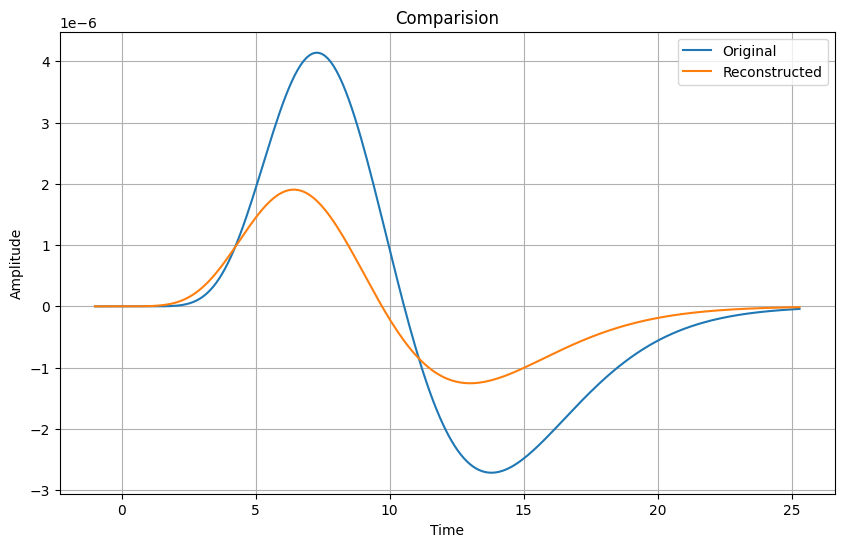

<Figure size 640x480 with 0 Axes>

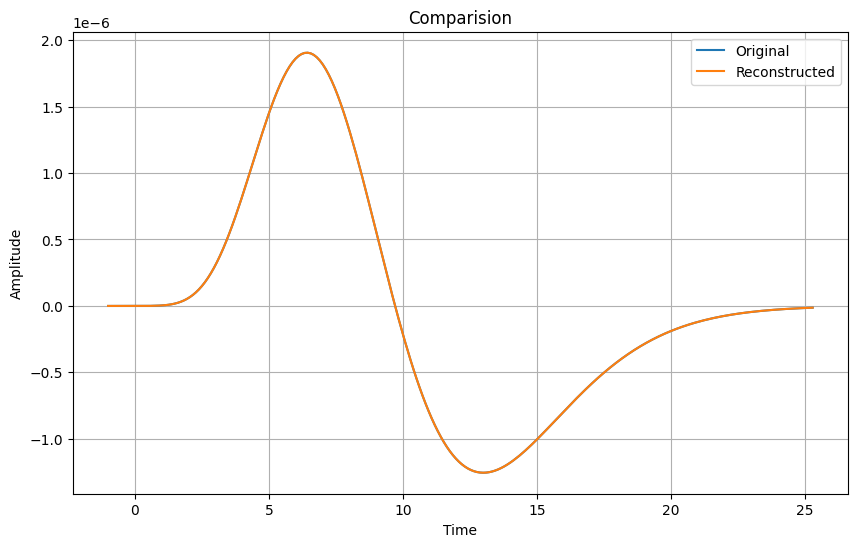

<Figure size 640x480 with 0 Axes>

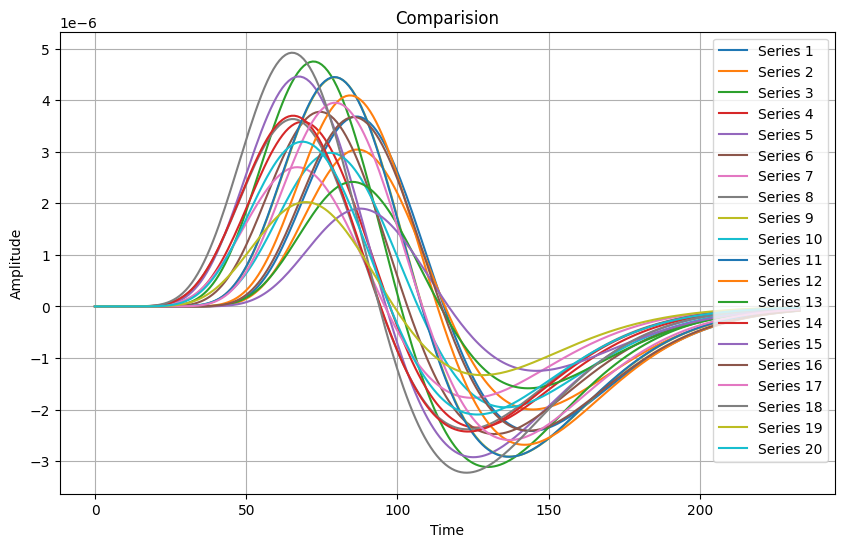

<Figure size 640x480 with 0 Axes>

In [495]:
# This is a demo of how data varies with generation.
displays.plot_comparision_data(generator.generate_hrf(time_signal, vary=True, shift_factor=0.1),generator.generate_hrf(time_signal), time_signal)
displays.plot_comparision_data(generator.generate_hrf(time_signal, vary=False),generator.generate_hrf(time_signal), time_signal)
displays.plot_many_comparision_series(generator.generate_hrf_set(20), time_signal)


In [496]:
# Actually generate, segment, etc... the data. (A demo to recreate my results)

# We're opting a 70%, 20%, 10% split on our data for training, validation and evaluation
# We also leave one final participant out to test on unseen participants
readings = real_haemo_data[:-1].flatten()

# We want a small subset to simulate the conditions an individual experiment, not focusing on 
# getting just resting state data, would have.
train_readings = real_haemo_data[:7].flatten() 
eval_readings = real_haemo_data[7: 9].flatten()
test_readings = real_haemo_data[-1].flatten()

real_data_overlays = return_rand_samples(train_readings, 1000, signal_length)
test_real_overlays = return_rand_samples(test_readings, 100, signal_length)
print("Real Data Overlays Complete")
auto_data_overlays = return_seg_samples(generator.generate_auto_reg_noise(train_readings, 1170000), signal_length) 
test_auto_overlays = return_seg_samples(generator.generate_auto_reg_noise(train_readings, 23400), signal_length) 
print("AutoRegressive Data Overlays Complete")
synt_data_overlays = return_seg_samples(generator.generate_synth_overlay(1170000), signal_length) # 5k * 234
test_synt_overlays = return_seg_samples(generator.generate_synth_overlay(23400), signal_length) # 100 * 234
print("Synthetic Data Overlays Complete")
hrf_target_signals = generator.generate_hrf_set(5000)
test_hrf_target_signals = generator.generate_hrf_set(100)
print(f"Real samples: {np.shape(real_data_overlays)}, AutoReg samples: {np.shape(auto_data_overlays)}, Synthetic Samples: {np.shape(synt_data_overlays)}")
print(f"The number of generated_hrfs is {np.shape(hrf_target_signals)}")


Real Data Overlays Complete
AutoRegressive Data Overlays Complete
Synthetic Data Overlays Complete
Real samples: (1000, 234), AutoReg samples: (5000, 234), Synthetic Samples: (5000, 234)
The number of generated_hrfs is (5000, 234)


In [497]:
# Here we pack all of the data into their datasets, dataloaders and so forth

synth_linear_dataset = time_series_wavelet_database(hrf_target_signals[:len(synt_data_overlays)], synt_data_overlays)
synth_dataloader = DataLoader(synth_linear_dataset, batch_size=64, shuffle=True)

real_linear_dataset = time_series_wavelet_database(hrf_target_signals[:len(real_data_overlays)], real_data_overlays)
real_dataloader = DataLoader(real_linear_dataset, batch_size=64, shuffle=True)

auto_reg_linear_dataset = time_series_wavelet_database(hrf_target_signals[:len(auto_data_overlays)], auto_data_overlays)
auto_reg_dataloader = DataLoader(auto_reg_linear_dataset, batch_size=64, shuffle=True)

synth_wavelet_dataset = padded_wavelet_database(hrf_target_signals[:len(synt_data_overlays)], synt_data_overlays)
synth_wavelet_dataloader = DataLoader(synth_wavelet_dataset, batch_size=64, shuffle=True)

print(f"The training dataloaders have length --> Synth:{len(synth_linear_dataset)}, Real:{len(real_linear_dataset)}, Auto:{len(auto_reg_linear_dataset)}, Synth_Wav{len(synth_wavelet_dataset)}")

# No need to cut to shape, because all the tests are 100 samples
test_synt_dataset = time_series_wavelet_database(test_hrf_target_signals, test_synt_overlays) 
# test_synt_dataloader = DataLoader(test_synt_dataset, batch_size = 20, shuffle = True)

test_real_dataset = time_series_wavelet_database(test_hrf_target_signals, test_real_overlays)
# test_real_dataloader = DataLoader(test_real_dataset, batch_size = 20, shuffle = True)

test_auto_dataset = time_series_wavelet_database(test_hrf_target_signals, test_auto_overlays)
# test_auto_dataloader = DataLoader(test_auto_dataset, batch_size = 20, shuffle = True)

# Add in a test wavelet one when we do that...

print(f"The test dataloaders have length --> {len(test_synt_dataset)}, {len(test_real_dataset)}, {len(test_auto_dataset)}")

The training dataloaders have length --> Synth:5000, Real:1000, Auto:5000, Synth_Wav5000
The test dataloaders have length --> 100, 100, 100


In [498]:
# These are the various different models that can be used to denoise an fNIRS signal. Some are for wavelets,
# some are for time series, some require particular signal lengths, so they may require slight parameter adjustments
# according to the dataset that you use.

# Some of these are just here to benchmark the models used in my results, and are probably best not to use other
# than for that purpose.

class basic_Lin_AE(nn.Module):
    # A really basic, standard linear denoising Auto-Encoder, for the time series represenation, without a
    # particularly optimised layout/ organisation.
    def __init__(self, signal_length=signal_length):
        super().__init__()
        self.signal_length = signal_length
        
        self.encoder_layer = nn.Sequential(
            nn.Linear(self.signal_length, 164),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(164, 84),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(84, 64),
            nn.LeakyReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            
            nn.Linear(32, 6),
        )
        
        self.decoder_layer = nn.Sequential(
            nn.Linear(6, 32),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            
            nn.Linear(32, 64),
            nn.LeakyReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(64, 84),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(84, 164),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(164, self.signal_length)
        )
        
    def forward(self, x):
        code = self.encoder_layer(x)
        # The latent space representation of the time series
        reconstruction = self.decoder_layer(code)
        # A reconstruction of the clean time series based on the latent space representation we extracted
        
        return reconstruction
        

class basic_CNN_AE(nn.Module):
    # A really basic CNN based Auto-encoder. 3 Layers of encoder and 4 of decoder. For time series rep.
    def __init__(self):
        super().__init__()
        
        self.encoder_layer = nn.Sequential(
            nn.Conv1d(1, 64, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            
            nn.Conv1d(64, 64, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            nn.Dropout(p=0.1),
            
            nn.Conv1d(64, 64, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
        )
        
        
        self.decoder_layer = nn.Sequential(
            nn.Conv1d(64, 64, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),


            nn.Conv1d(64, 64, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),

            
            nn.Conv1d(64, 64, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),
            
            nn.Conv1d(64, 1, 3, padding=2, stride=1)
        )
        
    def forward(self, x):
        code = self.encoder_layer(x)
        reconstruction = self.decoder_layer(code)
        return reconstruction


class benchmark_CNN_AE(nn.Module):
    # An implementation of a CNN auto-encoder, according to the approach of Yuanyuan et al.
    def __init__(self):
        super().__init__()
        
        self.encoder_layer = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            nn.Dropout(p=0.1),
            
            nn.Conv1d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            nn.Dropout(p=0.1),

            
            nn.Conv1d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            
            nn.Conv1d(32, 32, 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool1d(2, padding = 0),
            
        )
        
        self.decoder_layer = nn.Sequential(
            nn.Conv1d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),


            nn.Conv1d(32, 32, 3, padding = 2, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            nn.Dropout(p=0.1),

            
            nn.Conv1d(32, 32, 3, padding = 1, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            
            nn.Conv1d(32, 32, 3, padding = 0, stride=1),
            nn.LeakyReLU(),
            nn.Upsample(scale_factor=2),
            
            nn.Conv1d(32, 1, 3, padding=0, stride=1)
        )
        
    def forward(self, x):
        code = self.encoder_layer(x)
        reconstruction = self.decoder_layer(code)
        return reconstruction
    
class simple_LSTM_AE(nn.Module):
    # This is a simple LSTM based AutoEncoder, where a single LSTM layer extracts a latent space represenation of
    # the data in the encoder, and then in the decoder, a linear layer maps that back to clean signal.
    def __init__(self, signal_length=signal_length):
        super().__init__()
        
        self.encoder_layer = nn.LSTM(signal_length, 32, 1, batch_first = True)
        
        self.decoder_layer = nn.Linear(32, signal_length) # This acts as a fully connected layer basically
        
    def forward(self, x):
        code, (hidden_state_code, cell_state_code) = self.encoder_layer(x)
        # in this case, code is the output features at every time point in time series x.
        reconstruction = self.decoder_layer(code) 
        return reconstruction
    
class double_LSTM_AE(nn.Module):
    # An LSTM based AutoEncoder, using an LSTM layer as the encoder, and another (+ a fully connected linear layer)
    # as the decoder
    
    def __init__(self, signal_length=signal_length):
        super().__init__()
        
        self.encoder_layer = nn.LSTM(signal_length, 32, 1, batch_first = True)
        
        self.decoder_lstm = nn.LSTM(32, 32, 1, batch_first = True)
        self.fcl = nn.Linear(32, signal_length) # Fully connected layer, maps LSTM's features back to a time series
        
    def forward(self, x):
        code, (hidden_state_code, cell_state_code) = self.encoder_layer(x)
        decode, (hidden_state_decode, cell_state_decode) = self.decoder_layer(code)
        reconstruction = self.fcl(decode)
        
        return reconstruction
    
    
class deep_LSTM_AE(nn.Module):
    # This version uses a time series rep, with an LSTM encoder, decoder setup, except this time the number of hidden
    # cells is varied between layers in the encoder/ decoder.
    # This version allows for variable lengths of inputs. (although it does have to be input)
    
    # This version might have too many layers by the way. comebackto and create a version with an intermediary
    # between this and double_LSTM_AE, e.g. with 2 LSTM layers on either side maybe?
    
    def __init__(self, sig_len=signal_length):
        super().__init__()
        self.hidden_cell_number = [int(sig_len)] + [int(((sig_len // (2 ** i))) - ((sig_len // (2 ** i) % 2))) for i in range(1, 4)]
        # Just ensuring that they're even
        hcl_len = len(self.hidden_cell_number)
        # We'll go down this with the encoder then reverse for the decoder. Enables (predetermined at instanciation)
        # variable input length
        
        self.encoder_lstm_layers = nn.ModuleList()
        self.decoder_lstm_layers = nn.ModuleList()

        for layer in range(1, len(self.hidden_cell_number)):
            self.encoder_lstm_layers.append(nn.LSTM(self.hidden_cell_number[layer - 1], self.hidden_cell_number[layer], batch_first=True))
            self.encoder_lstm_layers.append(nn.Dropout(p=0.25))
            self.decoder_lstm_layers.append(nn.LSTM(self.hidden_cell_number[hcl_len - layer], self.hidden_cell_number[hcl_len - (layer + 1)], batch_first=True))
            self.decoder_lstm_layers.append(nn.Dropout(p=0.25))
            # input size, hidden cell number size for each LSTM's parameters

        print(self.encoder_lstm_layers)
        print(self.decoder_lstm_layers)
        self.fully_connected_layer = nn.Linear(self.hidden_cell_number[0], self.hidden_cell_number[0], bias=True)
        # Maps the final set of hidden cell information to reconstruct the actual sequence.
        
    def forward(self, x):
        for layer in self.encoder_lstm_layers:
            if isinstance(layer, nn.LSTM):
                x, (hidden_state, cell_state) = layer(x)
                hidden_state = torch.zeros(x.size(1), x.size(0), x.size(2))
                cell_state = torch.zeros(x.size(1), x.size(0), x.size(2))
            else:
                x = layer(x) 
                # dropout layers or regularisation layers have less outputs (1) than the LSTM layers (3)
        
        depth = 2
        for layer in self.decoder_lstm_layers:
            if isinstance(layer, nn.LSTM):
                hidden_state = torch.zeros(x.size(1), x.size(0), self.hidden_cell_number[-(depth)])
                cell_state = torch.zeros(x.size(1), x.size(0), self.hidden_cell_number[-(depth)])
                x, (hidden_state, cell_state) = layer(x, (hidden_state, cell_state))
                depth += 1
            else:
                x = layer(x)
        reconstructed = self.fully_connected_layer(x)
        
        return reconstructed

In [499]:
def basic_train_model(model_type, dataloader, loss_function=nn.MSELoss, epoch_number = 50, learning_rate = 1e-3):
    denoising_model = model_type()
    loss_func = loss_function()
    optimiser = optim.Adam(denoising_model.parameters(), lr=learning_rate)
    
    for epoch in range(epoch_number):
        for (clean, dirty) in dataloader:
            reconstructed = denoising_model(dirty)
            reconstruction_loss = loss_func(reconstructed, clean)
            optimiser.zero_grad()
            reconstruction_loss.backward()
            optimiser.step()
            
        print(f"The loss in epoch {epoch + 1} of {epoch_number} epochs is {reconstruction_loss.item():.4f}")
    
    return denoising_model

def saving_train_model(model_type, dataset, loss_function=nn.MSELoss, epoch_number = 50, learning_rate = 1e-4, validation_dataloader=None):
    # Only for the LSTM versions
    denoising_model = model_type()
    dataloader = DataLoader(dataset, batch_size = 256, shuffle = True)
    loss_func = loss_function()
    optimiser = optim.Adam(denoising_model.parameters(), lr=learning_rate)
    lowest_loss = float('inf')
    clip_thresh = .5 # Performs gradient clipping if any param's grad. exceeds this threshold. Prevents gradient exploding.
    
    if validation_dataloader is None:
        validation_dataloader = DataLoader(dataset, batch_size = 256, shuffle = True)
        
    for epoch in range(epoch_number):
        denoising_model.train()
        running_loss = 0
        for (clean, dirty) in dataloader:
            reconstructed = denoising_model(dirty)
            reconstruction_loss = loss_func(reconstructed, clean)
            optimiser.zero_grad()
            
            reconstruction_loss.backward()
            torch.nn.utils.clip_grad_norm_(denoising_model.parameters(), clip_thresh)

            optimiser.step()
            
        denoising_model.eval()        
        with torch.no_grad():
            for (clean, dirty) in validation_dataloader:
                reconstructed = denoising_model(dirty)
                reconstruction_loss = loss_func(reconstructed, clean)
                running_loss += reconstruction_loss.item()
            
        if running_loss < lowest_loss:
            print(f"In epoch {epoch+1}, loss {running_loss} beat {lowest_loss} and is now the lowest loss")
            lowest_loss = running_loss
            best_model_state_dict = denoising_model.state_dict().copy()
            torch.save(best_model_state_dict, "Current_best_model.pth")
            
        print(f"The total loss in epoch {epoch + 1} of {epoch_number} epochs is {running_loss:.4f}")
    
    best_model_state_dict = torch.load("Current_best_model.pth")
    denoising_model.load_state_dict(best_model_state_dict)
    print(f"The lowest loss was {lowest_loss}")
    return denoising_model

def basic_eval_model(model, dataset, loss_function, display_num = 1):
    loss_acc = 0.
    dataloader = DataLoader(dataset, batch_size = 20, shuffle = False)
    with torch.no_grad():
        model.eval()
        for (clean, dirty) in dataloader:
            reconstructed = model(dirty)
            loss_acc += loss_function(reconstructed.detach().numpy(), clean.detach().numpy())
    
    print(f"Total loss of {loss_acc}, with a mean loss of {loss_acc / len(dataloader)} in a sample size of {len(dataset)}")
    
    display_dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    iter_num = 0
    for display_clean, display_dirty in display_dataloader:
        if iter_num < display_num:
            display_recon = model(display_dirty).detach().numpy()[0][0]
            displays.plot_comparision_data(display_clean[0][0], display_recon, np.arange(len(display_recon)) * sample_rate) 
            displays.plot_comparision_data(display_dirty[0][0], display_recon, np.arange(len(display_recon)) * sample_rate) 
            iter_num += 1
            
def wavelet_eval_model(model, dataset, loss_function, display_num = 1):
    # takes in a padded dataset by the way, 
    loss_acc = 0.
    dataloader = DataLoader(dataset, batch_size = 20, shuffle = True)
    with torch.no_grad():
        model.eval()
        for (clean, dirty) in dataloader:
            reconstructed = model(dirty)
            loss_acc += loss_function(reconstructed.detach().numpy(), clean.detach().numpy())
    
    print(f"Total loss of {loss_acc}, with a mean loss of {loss_acc / len(dataloader)} in a sample size of {len(dataset)}")
    
    display_dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
    iter_num = 0
    for display_clean, display_dirty in display_dataloader:
        with torch.no_grad():
            model.eval()
            if iter_num < display_num:     
                display_recon = model(display_dirty).detach().numpy()[0]
                displays.plot_comp_wavedec_layer(display_clean[0][0].detach().numpy(), display_recon[0])
                displays.plot_wavedec_layer(display_recon[0])

                data_rev_rec = dataset.get_signal_back(display_recon, dataset.lengths)
                data_rev_cle = dataset.get_signal_back(display_clean[0].detach().numpy(), dataset.lengths)
                data_rev_dir = dataset.get_signal_back(display_dirty[0].detach().numpy(), dataset.lengths)
                displays.plot_comparision_data(data_rev_cle, data_rev_rec, range(len(data_rev_cle)))

                iter_num += 1


In [500]:
basic_test_Lin = basic_train_model(basic_Lin_AE, synth_dataloader, epoch_number = 25, learning_rate=1e-3) 

The loss in epoch 1 of 50 epochs is 0.1516
The loss in epoch 2 of 50 epochs is 0.1466
The loss in epoch 3 of 50 epochs is 0.1091
The loss in epoch 4 of 50 epochs is 0.0921
The loss in epoch 5 of 50 epochs is 0.0985
The loss in epoch 6 of 50 epochs is 0.0971
The loss in epoch 7 of 50 epochs is 0.1192
The loss in epoch 8 of 50 epochs is 0.0330
The loss in epoch 9 of 50 epochs is 0.0307
The loss in epoch 10 of 50 epochs is 0.0193
The loss in epoch 11 of 50 epochs is 0.0295
The loss in epoch 12 of 50 epochs is 0.0229
The loss in epoch 13 of 50 epochs is 0.0236
The loss in epoch 14 of 50 epochs is 0.0195
The loss in epoch 15 of 50 epochs is 0.0214
The loss in epoch 16 of 50 epochs is 0.0160
The loss in epoch 17 of 50 epochs is 0.0174
The loss in epoch 18 of 50 epochs is 0.0237
The loss in epoch 19 of 50 epochs is 0.0193
The loss in epoch 20 of 50 epochs is 0.0134
The loss in epoch 21 of 50 epochs is 0.0239
The loss in epoch 22 of 50 epochs is 0.0128
The loss in epoch 23 of 50 epochs is 0.00

In [501]:
basic_test_CNN = basic_train_model(basic_CNN_AE, synth_dataloader, epoch_number = 25, learning_rate=1e-3)

The loss in epoch 1 of 15 epochs is 0.0520
The loss in epoch 2 of 15 epochs is 0.0483
The loss in epoch 3 of 15 epochs is 0.1065
The loss in epoch 4 of 15 epochs is 0.0274
The loss in epoch 5 of 15 epochs is 0.0428
The loss in epoch 6 of 15 epochs is 0.0187
The loss in epoch 7 of 15 epochs is 0.0213
The loss in epoch 8 of 15 epochs is 0.0497
The loss in epoch 9 of 15 epochs is 0.0170
The loss in epoch 10 of 15 epochs is 0.0080
The loss in epoch 11 of 15 epochs is 0.0176
The loss in epoch 12 of 15 epochs is 0.0101
The loss in epoch 13 of 15 epochs is 0.0110
The loss in epoch 14 of 15 epochs is 0.0600
The loss in epoch 15 of 15 epochs is 0.0120


In [503]:
benchmark_test_CNN = basic_train_model(benchmark_CNN_AE, synth_dataloader, epoch_number=25, learning_rate=1e-3)

The loss in epoch 1 of 25 epochs is 0.1059
The loss in epoch 2 of 25 epochs is 0.0990
The loss in epoch 3 of 25 epochs is 0.1202
The loss in epoch 4 of 25 epochs is 0.0197
The loss in epoch 5 of 25 epochs is 0.0240
The loss in epoch 6 of 25 epochs is 0.0108
The loss in epoch 7 of 25 epochs is 0.0106
The loss in epoch 8 of 25 epochs is 0.0195
The loss in epoch 9 of 25 epochs is 0.0067
The loss in epoch 10 of 25 epochs is 0.0081
The loss in epoch 11 of 25 epochs is 0.0078
The loss in epoch 12 of 25 epochs is 0.0084
The loss in epoch 13 of 25 epochs is 0.0047
The loss in epoch 14 of 25 epochs is 0.0065
The loss in epoch 15 of 25 epochs is 0.0075
The loss in epoch 16 of 25 epochs is 0.0121
The loss in epoch 17 of 25 epochs is 0.0065
The loss in epoch 18 of 25 epochs is 0.0047
The loss in epoch 19 of 25 epochs is 0.0044
The loss in epoch 20 of 25 epochs is 0.0111
The loss in epoch 21 of 25 epochs is 0.0051
The loss in epoch 22 of 25 epochs is 0.0075
The loss in epoch 23 of 25 epochs is 0.00

In [514]:
deep_test_LSTM = basic_train_model(deep_LSTM_AE, synth_dataloader, epoch_number=25, learning_rate=1e-3)

ModuleList(
  (0): LSTM(234, 116, batch_first=True)
  (1): Dropout(p=0.25, inplace=False)
  (2): LSTM(116, 58, batch_first=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): LSTM(58, 28, batch_first=True)
  (5): Dropout(p=0.25, inplace=False)
)
ModuleList(
  (0): LSTM(28, 58, batch_first=True)
  (1): Dropout(p=0.25, inplace=False)
  (2): LSTM(58, 116, batch_first=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): LSTM(116, 234, batch_first=True)
  (5): Dropout(p=0.25, inplace=False)
)
The loss in epoch 1 of 25 epochs is 0.0997
The loss in epoch 2 of 25 epochs is 0.1082
The loss in epoch 3 of 25 epochs is 0.0605
The loss in epoch 4 of 25 epochs is 0.0882
The loss in epoch 5 of 25 epochs is 0.0494
The loss in epoch 6 of 25 epochs is 0.0647
The loss in epoch 7 of 25 epochs is 0.1504
The loss in epoch 8 of 25 epochs is 0.0631
The loss in epoch 9 of 25 epochs is 0.1065
The loss in epoch 10 of 25 epochs is 0.1193
The loss in epoch 11 of 25 epochs is 0.1043
The loss in epoch 12 of 25 epochs i

In [516]:
shallow_test_LSTM = basic_train_model(simple_LSTM_AE, synth_dataloader, epoch_number=25, learning_rate=1e-3)

The loss in epoch 1 of 25 epochs is 0.2257
The loss in epoch 2 of 25 epochs is 0.0165
The loss in epoch 3 of 25 epochs is 0.0451
The loss in epoch 4 of 25 epochs is 0.0032
The loss in epoch 5 of 25 epochs is 0.0043
The loss in epoch 6 of 25 epochs is 0.0030
The loss in epoch 7 of 25 epochs is 0.0019
The loss in epoch 8 of 25 epochs is 0.0009
The loss in epoch 9 of 25 epochs is 0.0007
The loss in epoch 10 of 25 epochs is 0.0116
The loss in epoch 11 of 25 epochs is 0.0010
The loss in epoch 12 of 25 epochs is 0.0013
The loss in epoch 13 of 25 epochs is 0.0110
The loss in epoch 14 of 25 epochs is 0.0004
The loss in epoch 15 of 25 epochs is 0.0004
The loss in epoch 16 of 25 epochs is 0.0004
The loss in epoch 17 of 25 epochs is 0.0007
The loss in epoch 18 of 25 epochs is 0.0006
The loss in epoch 19 of 25 epochs is 0.0003
The loss in epoch 20 of 25 epochs is 0.0052
The loss in epoch 21 of 25 epochs is 0.0004
The loss in epoch 22 of 25 epochs is 0.0003
The loss in epoch 23 of 25 epochs is 0.00

---------------------------- Basic Linear Model ----------------------------
Total loss of 0.18387076530672003, with a mean loss of 0.036774153061344 in a sample size of 100


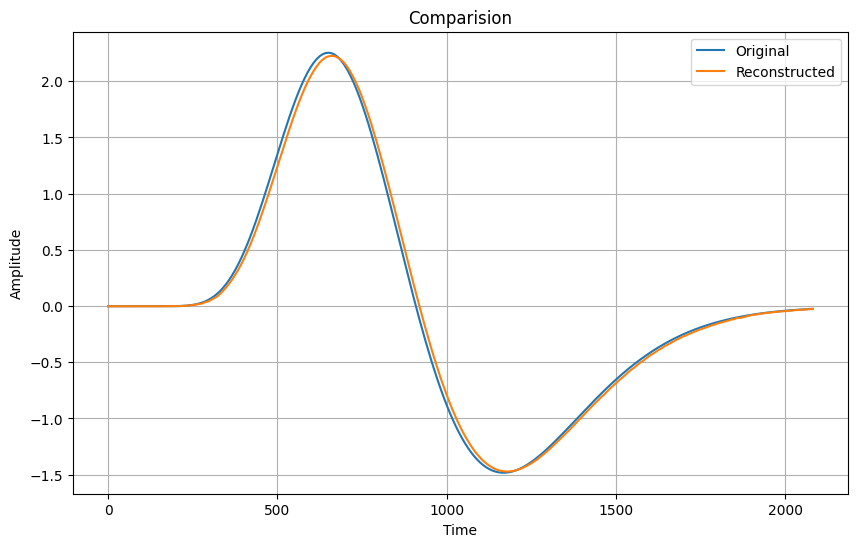

<Figure size 640x480 with 0 Axes>

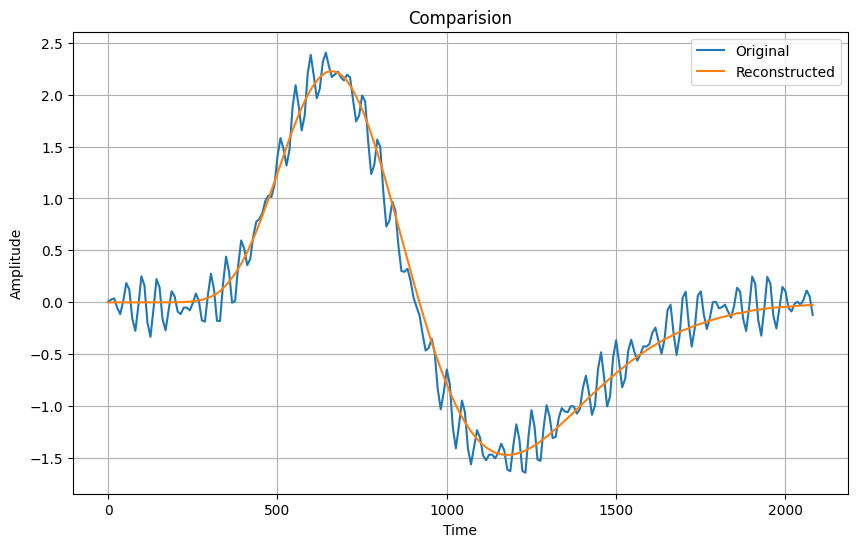

---------------------------- Basic CNN Model ----------------------------
Total loss of 0.32463296040559125, with a mean loss of 0.06492659208111826 in a sample size of 100


<Figure size 640x480 with 0 Axes>

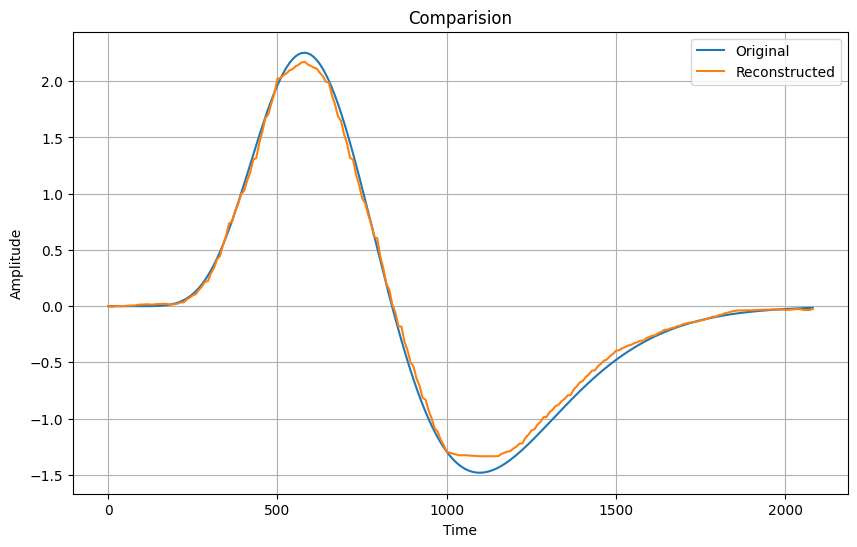

<Figure size 640x480 with 0 Axes>

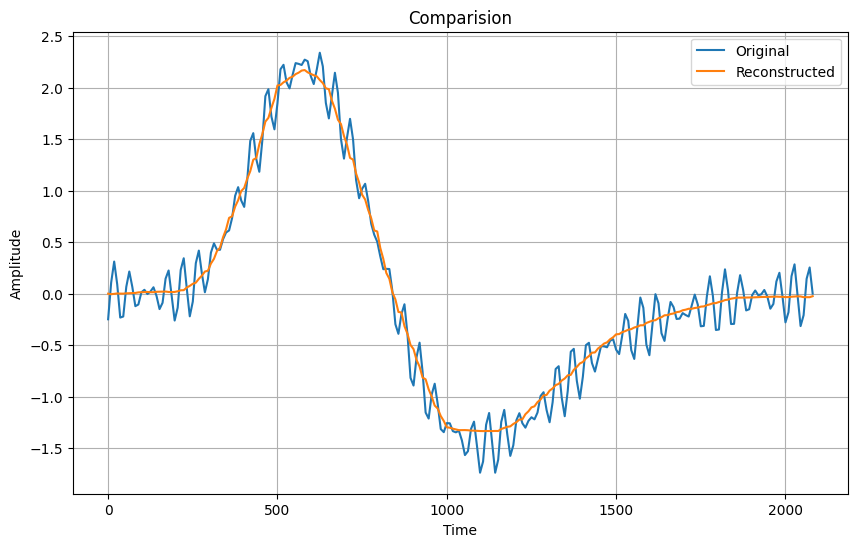

---------------------------- Benchmark CNN Model ----------------------------
Total loss of 0.3021248545297052, with a mean loss of 0.060424970905941046 in a sample size of 100


<Figure size 640x480 with 0 Axes>

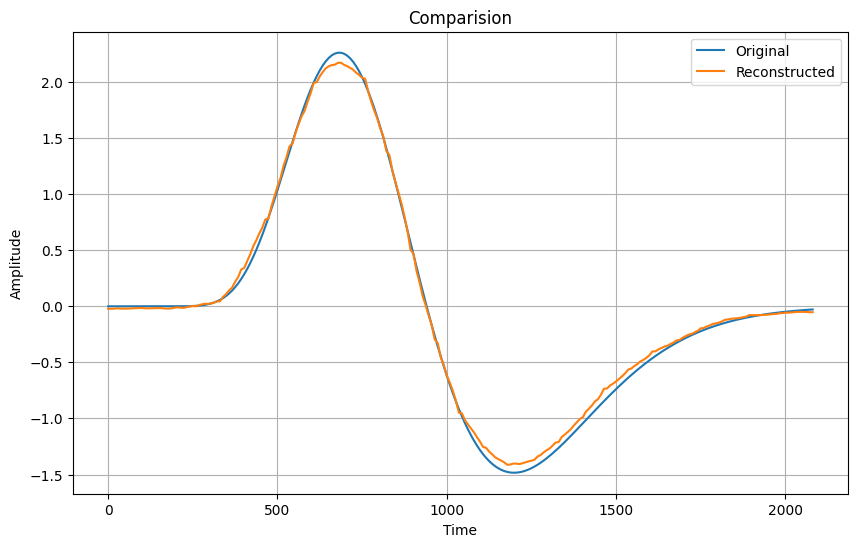

<Figure size 640x480 with 0 Axes>

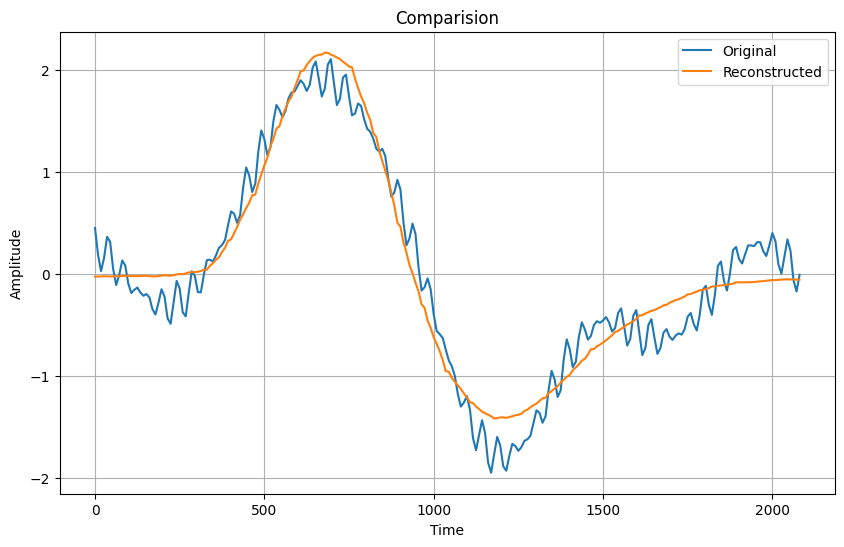

---------------------------- Shalow LSTM Model ----------------------------
Total loss of 0.1320322200916958, with a mean loss of 0.026406444018339158 in a sample size of 100


<Figure size 640x480 with 0 Axes>

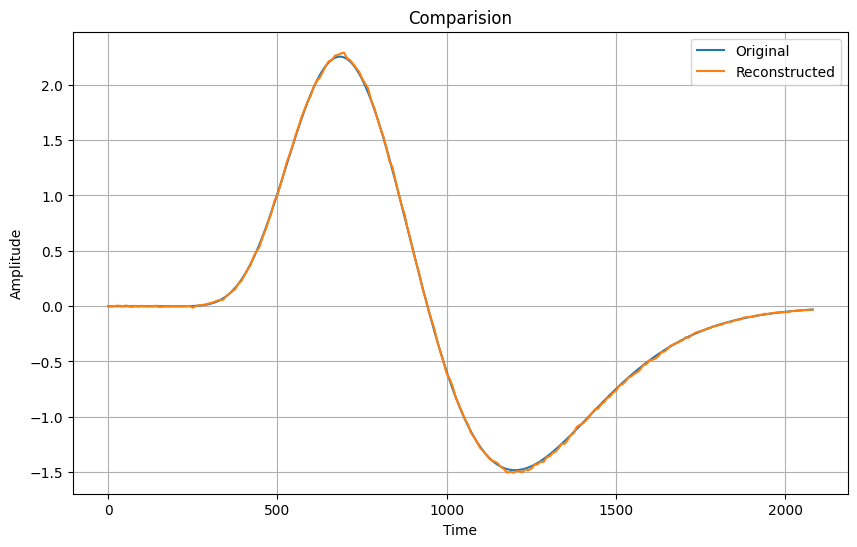

<Figure size 640x480 with 0 Axes>

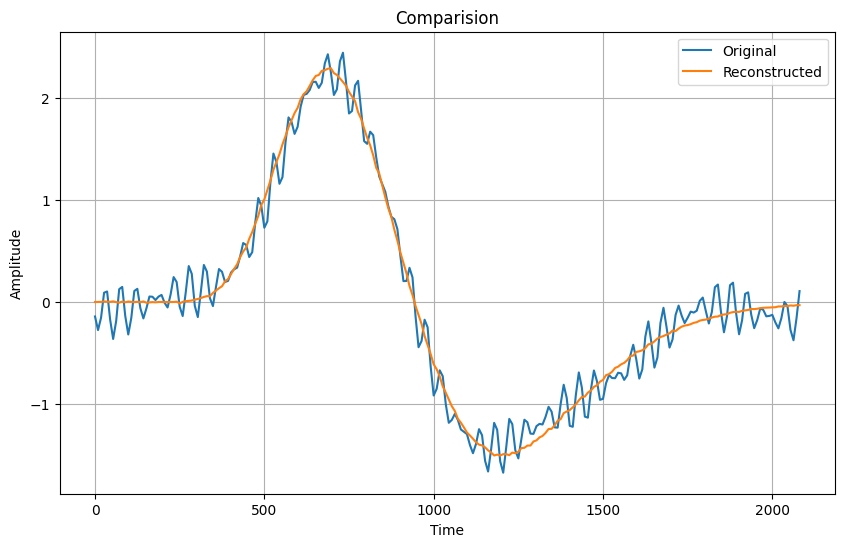

---------------------------- Deep LSTM Model ----------------------------
Total loss of 0.12448588598999812, with a mean loss of 0.024897177197999623 in a sample size of 100


<Figure size 640x480 with 0 Axes>

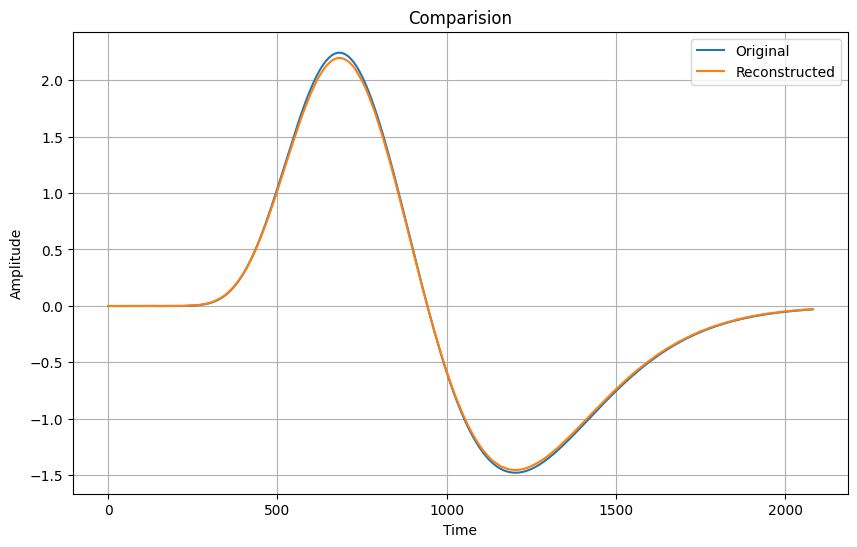

<Figure size 640x480 with 0 Axes>

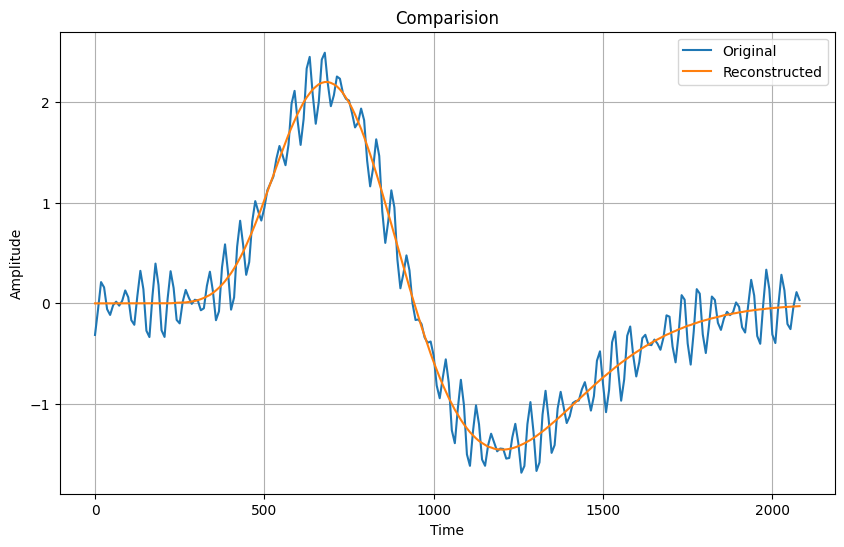

<Figure size 640x480 with 0 Axes>

In [517]:
# Evaluation
print("---------------------------- Basic Linear Model ----------------------------")
basic_eval_model(basic_test_Lin, test_synt_dataset, evals.root_mean_square_error, display_num=1)
print("---------------------------- Basic CNN Model ----------------------------")
basic_eval_model(basic_test_CNN, test_synt_dataset, evals.root_mean_square_error, display_num=1)
print("---------------------------- Benchmark CNN Model ----------------------------")
basic_eval_model(benchmark_test_CNN, test_synt_dataset, evals.root_mean_square_error, display_num=1)
print("---------------------------- Shalow LSTM Model ----------------------------")
basic_eval_model(shallow_test_LSTM, test_synt_dataset, evals.root_mean_square_error, display_num=1)
print("---------------------------- Deep LSTM Model ----------------------------")
basic_eval_model(deep_test_LSTM, test_synt_dataset, evals.root_mean_square_error, display_num=1)

                 
                 
# test_real_dataloader
# test_auto_dataloader